In [13]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import time
import numpy as np
from imutils import paths

For this notebook, we have cherry picked a couple of examples under `data/handpicked` which were used to develop the postprocessing algorthms to identify the eyes and add googly eyes. 


# Find the eyes

In [6]:
DATA_PATH = Path("../data/handpicked")
MODEL_PATH = Path("../exp/weights.pt")

In [7]:
image_paths = list(paths.list_images(DATA_PATH))
len(image_paths)


5

In [270]:
class Model:
    def __init__(self, model_path: Path):
        if torch.cuda.is_available():
            self.model = torch.load(MODEL_PATH)
        else:
            self.model = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def predict(self, img: np.ndarray):
        try:
            original_shape = img.shape[:2]
            img = self._pre_process(img)
            with torch.no_grad():
                if torch.cuda.is_available():
                    tensor = torch.from_numpy(img).to(self.device).type(torch.cuda.FloatTensor)/255
                else:
                    tensor = torch.from_numpy(img).to(self.device).type(torch.FloatTensor)/255
                
                pred = self.model(tensor)
            
            out_img = pred['out'].cpu().detach().numpy()[0]
            out_img = self._post_process(out_img, original_shape)
            return out_img
        except ValueError as err:
            print(f"Something went wrong when running predictions: {err}")
        
    def _pre_process(self, img: np.ndarray) -> np.ndarray:
        # resize to confortable but conservative shape to keep inference time consistent
        img = cv2.resize(img, (512, 512), cv2.INTER_AREA).transpose(2,0,1)
        # reshape to add batch dimension to 1
        img = img.reshape(1, 3, img.shape[1],img.shape[2])

        return img

    def _post_process(self, img: np.ndarray, original_shape: tuple):
        # channel last
        img = img.transpose(1,2,0)
        # resize back to original shape
        img = cv2.resize(img, original_shape[::-1], cv2.INTER_AREA)
        # convert image to uint8 to be consistent with input image
        img = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

        return img


model = Model(MODEL_PATH)

In [272]:
image = cv2.imread(image_paths[4])
pred = model.predict(image)
assert image.shape == pred.shape

(280, 300, 3)
5


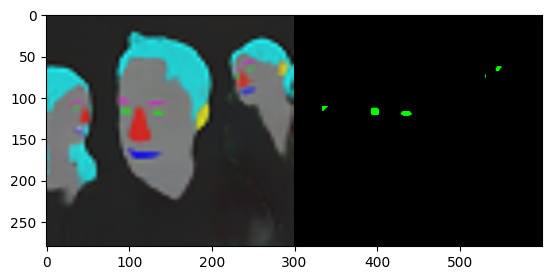

In [271]:
image = cv2.imread(image_paths[3])
#image = cv2.imread("../data/external/_127471632_vauxhallbridgewoman.jpg")

img = model.predict(image)
print(img.shape)
montage = None
montage = img
plt.imshow(img)

img = np.copy(img)

green_lo = np.array([0,150,0])
green_hi = np.array([100,255,100])
mask=cv2.inRange(img,green_lo,green_hi)
img[mask>0]=(0,255,0)
img[mask==0]=(0,0,0)

montage = np.hstack([montage, img])

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img, 127, 255, 0)
img = img.astype(np.uint8)
#montage = np.hstack([montage, img])

contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
#montage = np.hstack([montage, img])
print(len(contours))

plt.imshow(montage)

Make a function out of it.

In [397]:
from scipy.spatial.distance import pdist, squareform
from typing import List, Tuple

def find_eyes(img: np.ndarray):
    """Find eyes in the image.

    This method processes the img prediction of the NN behind which was trained
    to mark every identified eye pixel as green (0, 255, 0). Since the model is
    not perfect, some pixels are not exactly the same green, so this method needs
    to first threshold the greens before anything.

    After that the eyes are identified and processed into a list of tuples, on per eye.
    Each tuple consists of (<center_of_the_eye_coordinates>, <diameter_of_the_eye>).
    """
    # mask only eye pixels
    green_lo = np.array([0,150,0])
    green_hi = np.array([100,255,100])
    mask=cv2.inRange(img,green_lo,green_hi)
    img[mask>0] = (0,255,0)  # unify eye color for all eye pixels within the range of search
    img[mask==0] = (0,0,0)  # make everything else black

    # find clusters of green or in other words, find the eyes
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 127, 255, 0)
    img = img.astype(np.uint8)

    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # process the eyes
    eyes = []
    for contour in contours:
        top_left_pixel = np.min(contour, axis=(0,1))
        bottom_right_pixel = np.max(contour, axis=(0,1))

        # average
        eye_center = np.round((top_left_pixel + bottom_right_pixel)/2)

        # euclidean distance
        #eye_diameter = np.sqrt(np.sum((bottom_right_pixel-top_left_pixel)**2))
        distances = squareform(pdist(contour.reshape(contour.shape[0], contour.shape[2])))
        eye_diameter = np.max(distances)

        eyes.append((eye_center.astype(int).tolist(), round(eye_diameter)))
    
    return eyes

# Add goofy eyes

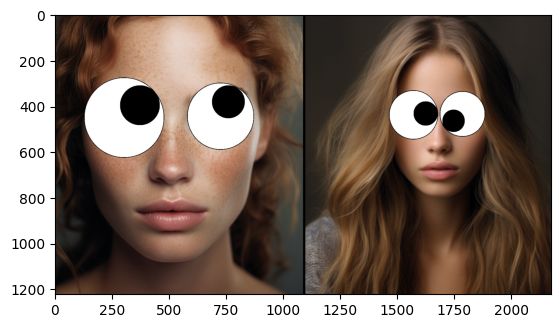

In [400]:
import math
image = cv2.imread(image_paths[3])
image = cv2.imread("../data/external/_127471632_vauxhallbridgewoman.jpg")
image = cv2.imread("../data/handpicked/beautiful-faces.png")
pred = model.predict(image)

eyes = find_eyes(pred)
for center, diameter in eyes:
    diameter = round(diameter)
    cv2.circle(image, center, diameter, color=(0,0,0), thickness=2)
    cv2.circle(image, center, diameter-1, color=(255,255,255), thickness=-1)

    radius = round(diameter*0.5)
    random_angle = np.random.randint(360)
    random_x = center[0] + round(radius * math.cos(random_angle))
    random_y = center[1] + round(radius * math.sin(random_angle))

    cv2.circle(image, (random_x, random_y), round(diameter*0.5), color=(0,0,0), thickness=-1)

image = image[:,:,::-1]
plt.imshow(image)
